SBA paper: exploration of correlations between loan amount, salary, geography, business size and type

Initial definitions

In [ ]:
import glob
import pandas as pd
import zipfile
from plotnine import *    # python lib to use ggplot
import numpy as np
# libs for regression
import statsmodels.api as sm
from patsy import dmatrices
    
naics = 'NAICS2'  # or 'NAICS3'
scope = 'US'  # 'NE' for New England or 'US'

if scope == 'NE':
    NEstates = ['CT','MA','ME','NH','RI','VT']
    NEstfips = ['09','25','23','33','44','50']

def OverrideNAICS2(df):
    # adjusts 2-digit NAICS that are joint, e.g. NAICS 31-33 Manufacturing
    df.loc[df['NAICS2'].eq('31'),'NAICS2'] = '31-33'
    df.loc[df['NAICS2'].eq('33'),'NAICS2'] = '31-33'
    df.loc[df['NAICS2'].eq('44'),'NAICS2'] = '44-45' # NAICS 44-45 Retail trade
    df.loc[df['NAICS2'].eq('45'),'NAICS2'] = '44-45' # NAICS 44-45 Retail trade
    df.loc[df['NAICS2'].eq('48'),'NAICS2'] = '48-49' # 	NAICS 48-49 Transportation and warehousing
    df.loc[df['NAICS2'].eq('49'),'NAICS2'] = '48-49' # 	NAICS 48-49 Transportation and warehousing
    return df

read PPP loan data

In [ ]:
fpath = '/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/120120 Paycheck Protection Program Data/'
#fpath = '/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/'

csv_files = glob.glob(fpath + '*.csv')

list_df = []
for csv_file in csv_files:
    print(csv_file)
    df = pd.read_csv(csv_file, dtype={'Zip':'object', 'NAICSCode':'object'})
    # do df manipulations
    list_df.append(df)

df = pd.concat(list_df)
loans = df.assign( NAICS2 = df.NAICSCode.str.slice(start=0, stop=2)
               , NAICS3 = df.NAICSCode.str.slice(start=0, stop=3) )

/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/public_up_to_150k_8.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/public_150k_plus.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/public_up_to_150k_3.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/public_up_to_150k_2.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/public_up_to_150k_1.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/public_up_to_150k_5.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/public_up_to_150k_4.csv
/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/03-03-21 Paycheck Protection Program Data/public_up_t

Some filtering

In [ ]:
# First round of PPP only
loans['DateApproved'] = pd.to_datetime( loans['DateApproved'] )
loans = loans[loans['DateApproved'] < '2020-09-01']

# should keep loan data for New England only?
if scope == 'NE':
    loans = loans[loans['State'].isin(NEstates)]

# for compatibility with previous column names
#loans = loans.rename(columns={'InitialApprovalAmount':'LoanAmount','BorrowerZip':'Zip'})

# keep loan data for New England only
nloans = loans.shape[0]
totAmnt = loans['LoanAmount'].sum()
print(scope, 'PPP loans:{0:,.0f}'.format(nloans) )
print(scope, 'Total PPP loan Amount:', totAmnt)
print(scope, 'PPP loans with valid NAICS:', loans[~loans.NAICSCode.isna()].shape[0] / nloans )
print(scope, 'PPP loans with non-empty Zipcode:', loans[~loans.Zip.str.strip().eq('')].shape[0] / nloans )
print(scope, 'PPP loans with non-empty BusinessType:', loans[~loans.BusinessType.str.strip().eq('')].shape[0] / nloans )
#print(scope, 'PPP loans with answered RaceEthnicity:', loans[~loans.RaceEthnicity.str.strip().eq('Unanswered')].shape[0] / nloans )
print(scope, 'PPP loans with answered Race:', loans[~loans.Race.str.strip().eq('Unanswered')].shape[0] / nloans )
print(scope, 'PPP loans with answered Ethnicity:', loans[~loans.Ethnicity.str.strip().eq('Unanswered')].shape[0] / nloans )
print(scope, 'PPP loans with answered Gender:', loans[~loans.Gender.str.strip().eq('Unanswered')].shape[0] / nloans )
print(scope, 'PPP loans with answered Veteran:', loans[~loans.Veteran.str.strip().eq('Unanswered')].shape[0] / nloans )
print(scope, 'PPP loans with answered NonProfit:', loans[~loans.NonProfit.isna()].shape[0] / nloans )

loans.to_csv('/Users/aligo/Box/1 RisknDecScience/FEMA recovery/SBA paper/data/PPPloans' + scope + '.csv')
#if scope == 'US':
#    loans.sample(n=500000, random_state=1).to_csv(
#    '/Users/aligo/Box/1 RisknDecScience/FEMA recovery/SBA paper/data/PPPloansSAMPLE_' + scope + '.csv')

tmp = loans['State'].unique()
tmp = np.sort(loans[~loans['State'].isna()]['State'].unique())
tmp = np.sort(loans[loans['LoanAmount'].le(150e3) & ~loans['State'].isna()]['State'].unique())
tmp = np.sort(loans[loans['LoanAmount'].gt(150e3) & ~loans['State'].isna()]['State'].unique())

US PPP loans: 5146978
US Total PPP loan Amount: 526508130554.8702
US PPP loans with valid NAICS: 0.9741994234286605
US PPP loans with non-empty Zipcode: 1.0
US PPP loans with non-empty BusinessType: 1.0
US PPP loans with answered Race: 0.13514046494855816
US PPP loans with answered Ethnicity: 1.0
US PPP loans with answered Gender: 0.27379075643999257
US PPP loans with answered Veteran: 0.2023249370795834
US PPP loans with answered NonProfit: 0.03506523633868262


KeyError: 'State'

list and save Loans' business types

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


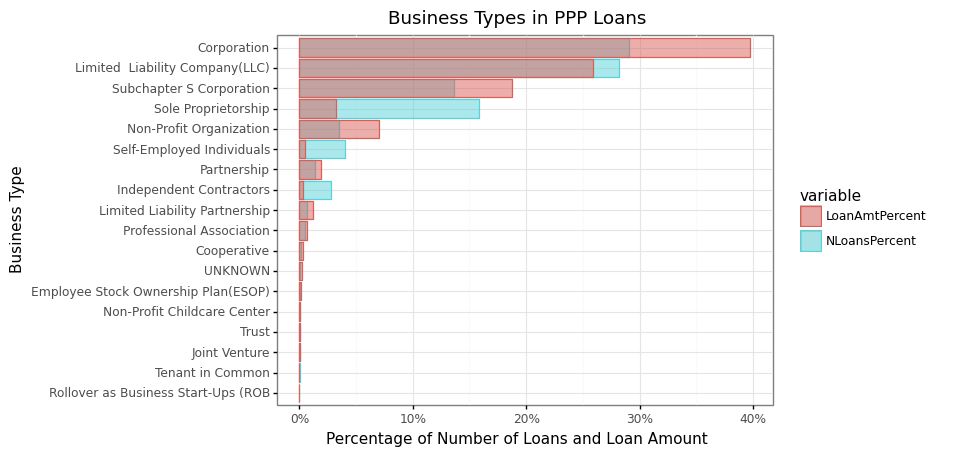

<ggplot: (8782413131337)>

In [ ]:
biztypes = loans.groupby('BusinessType').agg({'State':'count','LoanAmount':'sum'})
idx = loans['BusinessType'].isna()
biztypes.loc['UNKNOWN'] = [idx.sum(), loans.loc[idx,'LoanAmount'].sum()]
biztypes['NLoansPercent'] = biztypes['State'] / nloans
biztypes['LoanAmtPercent'] = biztypes['LoanAmount'] / totAmnt
biztypes = biztypes[['NLoansPercent','LoanAmtPercent']].reset_index().melt(id_vars=['BusinessType'])

ggplot(biztypes, aes(x='reorder(BusinessType,value)', y='value',color='variable',fill='variable')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
#          ) + scale_alpha_manual(values=[.1, .3]
          ) + theme_bw(
          ) + xlab('Business Type'
          ) + ylab('Percentage of Number of Loans and Loan Amount'
          ) + ggtitle('Business Types in PPP Loans'
          ) + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          ) + coord_flip()
#fpath = '/Users/aligo/Downloads/FEMA recovery data/PPP_loans_from_SBA/'
#with pd.ExcelWriter(fpath + 'PPP_business_types.xlsx') as writer:
#    biztypes[['NLoansPercent','LoanAmtPercent']].to_excel(writer, sheet_name='PPP', index=True)


plot race

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


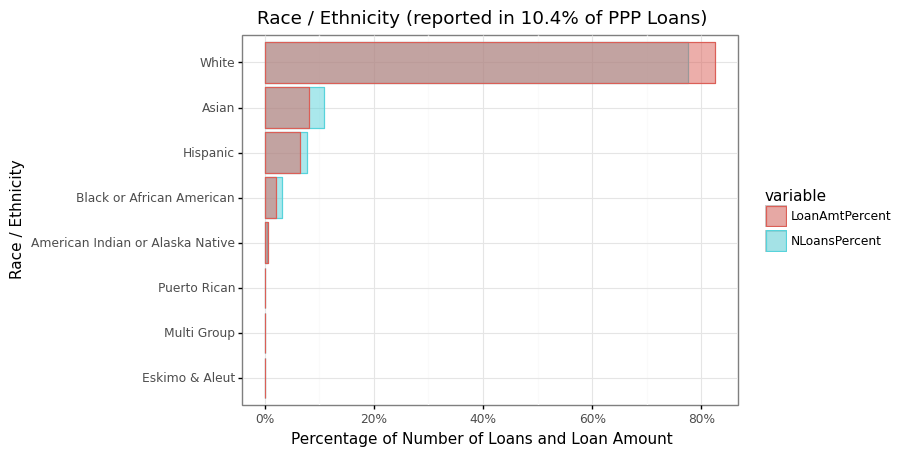

<ggplot: (8782411513381)>

In [ ]:
race = loans[~loans.RaceEthnicity.str.strip().eq('Unanswered')].groupby('RaceEthnicity'
                                    ).agg({'State':'count','LoanAmount':'sum'})
race['NLoansPercent'] = race['State'] / race['State'].sum()
race['LoanAmtPercent'] = race['LoanAmount'] / race['LoanAmount'].sum()
race = race[['NLoansPercent','LoanAmtPercent']].reset_index().melt(id_vars=['RaceEthnicity'])

ggplot(race, aes(x='reorder(RaceEthnicity,value)', y='value',color='variable',fill='variable')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
          ) + theme_bw(
          ) + xlab('Race / Ethnicity'
          ) + ylab('Percentage of Number of Loans and Loan Amount'
          ) + ggtitle('Race / Ethnicity (reported in 10.4% of PPP Loans)'
          ) + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          ) + coord_flip()

plot gender

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


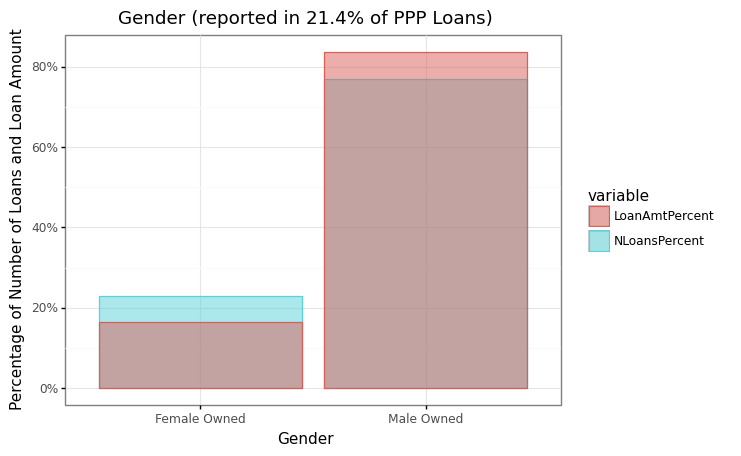

<ggplot: (8782411672761)>

In [ ]:
gender = loans[~loans.Gender.str.strip().eq('Unanswered')].groupby('Gender'
                                    ).agg({'State':'count','LoanAmount':'sum'})
gender['NLoansPercent'] = gender['State'] / gender['State'].sum()
gender['LoanAmtPercent'] = gender['LoanAmount'] / gender['LoanAmount'].sum()
gender = gender[['NLoansPercent','LoanAmtPercent']].reset_index().melt(id_vars=['Gender'])

ggplot(gender, aes(x='reorder(Gender,value)', y='value',color='variable',fill='variable')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
          ) + theme_bw(
          ) + xlab('Gender'
          ) + ylab('Percentage of Number of Loans and Loan Amount'
          ) + ggtitle('Gender (reported in 21.4% of PPP Loans)'
          ) + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          ) 

plot veteran status

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


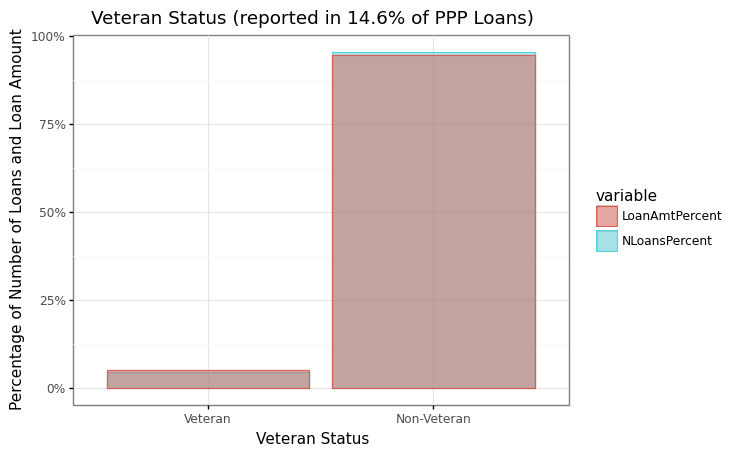

<ggplot: (8782411713485)>

In [ ]:
veteran = loans[~loans.Veteran.str.strip().eq('Unanswered')].groupby('Veteran'
                                    ).agg({'State':'count','LoanAmount':'sum'})
veteran['NLoansPercent'] = veteran['State'] / veteran['State'].sum()
veteran['LoanAmtPercent'] = veteran['LoanAmount'] / veteran['LoanAmount'].sum()
veteran = veteran[['NLoansPercent','LoanAmtPercent']].reset_index().melt(id_vars=['Veteran'])

ggplot(veteran, aes(x='reorder(Veteran,value)', y='value',color='variable',fill='variable')
          ) + geom_bar(stat="identity", position ="identity",alpha=0.5
          ) + theme_bw(
          ) + xlab('Veteran Status'
          ) + ylab('Percentage of Number of Loans and Loan Amount'
          ) + ggtitle('Veteran Status (reported in 14.6% of PPP Loans)'
          ) + scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]
          )

## Exclude loans to sole proprietors, contractors etc

In [ ]:
soleprop = ['Independent Contractors' #,'Self-Employed Individuals'
            ,'Sole Proprietorship', 'Tenant in Common']
loansCorp = loans[~loans.BusinessType.isin(soleprop)]
print(loansCorp.shape[0], 'loans in PPP dataset excluding', soleprop)

4194074 loans in PPP dataset excluding ['Independent Contractors', 'Sole Proprietorship', 'Tenant in Common']


# Join County info into each loan 

In [ ]:
loansc = loansCorp.reset_index().drop(columns='index')
loansc['cityc'] = loansc['City'].str.upper()
# clean 'city', 'town' etc from city name
remove_words = ['TOWN', 'CITY', 'PLANTATION','CCD','TOWNSHIP','PRECINCT','BOROUGH','DISTRICT']
patremove = r'\b(?:{})\b'.format('|'.join(remove_words))
loansc['cityc'] = loansc['cityc'].str.replace(patremove, '',regex=True).str.strip()
# remove whitespaces
loansc['cityc'] = loansc['cityc'].str.replace(r'[^A-Z ]+','',regex=True).str.strip()

loancities = loansc[['State','cityc']].drop_duplicates().reset_index().drop(
                        columns='index').rename(columns={'State':'StateAbb'})
tmp = loansc.rename(columns={'State':'StateAbb'}).set_index(['StateAbb','cityc'])
tmp = tmp[~tmp.index.duplicated(keep='first')]
loancities = loancities.set_index(['StateAbb','cityc']).join(tmp[['City','Address','Zip']])

#'https://www2.census.gov/geo/docs/maps-data/data/comp/cousub_comparabilityxls.zip'
fpath = '/Users/aligo/Downloads/FEMA recovery data/'
zf = zipfile.ZipFile( fpath + 'cousub_comparabilityxls.zip') 
citycounty = pd.read_excel(zf.open('Cousub_comparability.xlsx'), engine='openpyxl'
                           , dtype={'STATEFP10':'object','COUNTYFP10':'object'})
citycounty = citycounty[#citycounty.STATEFP10.isin(NEstfips) &
                ~citycounty['NAMELSAD10'].eq('County subdivisions not defined')]
# state abbreviations
stabbr = pd.read_csv(fpath + 'state_fips_names.csv', dtype='str')
stabbr[' st'] = stabbr[' st'].str.strip()
stabbr[' stusps'] = stabbr[' stusps'].str.strip()
stabbr = stabbr.set_index(' st').rename(columns={' stusps':'StateAbb'})
citycounty = citycounty.set_index('STATEFP10').join(stabbr).reset_index().rename(
                                                columns={"index": "STATEFP10"} )

citycounty['COUNTYName'] = citycounty['FULLNAMELSAD10'].str.extract('(, .*(?= County,))')
citycounty['COUNTYName'] = citycounty['COUNTYName'].str[2:]

# clean 'city', 'town' etc from city name
citycounty['cityc'] = citycounty['NAMELSAD10'].str.upper().str.replace(
                                        patremove, '',regex=True).str.strip()

tmp = citycounty.set_index(['StateAbb','cityc'])
tmp = tmp[~tmp.index.duplicated(keep='last')]
loancities = loancities.join(tmp)[['City','STATEFP10','COUNTYFP10','NAMELSAD10'
                                   ,'FULLNAMELSAD10','COUNTYName']].reset_index()
print('unique cities in loan dataset: ' + str(loancities.shape[0]))
print('Unique matches: ' + str(loancities['COUNTYName'].notna().sum()))
print('Unique non-matches: ' + str(loancities['COUNTYName'].isna().sum()))
loancities.to_excel('/Users/aligo/Downloads/tmp/ppp addresses.xlsx')

loancities['COUNTYfips'] = loancities['STATEFP10'] + loancities['COUNTYFP10']
tmp = loansc.rename(columns={'State':'StateAbb'}).set_index(['StateAbb','cityc'])
tmp2 = loancities.set_index(['StateAbb','cityc'])[['COUNTYfips','COUNTYName']]
loansc = tmp.join(tmp2)
print('loans in loan dataset: ' + str(loansc.shape[0]))
print('loans with matches: ' + str(loansc['COUNTYName'].notna().sum()))
print('loans non-matches: ' + str(loansc['COUNTYName'].isna().sum()))

# ZIPcode to County Code crosswalk from https://www.huduser.gov/portal/datasets/usps_crosswalk.html#data
zipcounty = pd.read_excel('/Users/aligo/Downloads/FEMA recovery data/ZIP_COUNTY_092020.xlsx'
                      , engine='openpyxl', usecols=['ZIP','COUNTY','TOT_RATIO']
                , dtype={'ZIP':'object','COUNTY':'object','TOT_RATIO':'float64'})
#zipcounty = zipcounty.reset_index()
nzc = zipcounty.shape[0]
print('zip-county pairs in US: ' + str(nzc))
zipcounty['maxtot'] = zipcounty.groupby(['ZIP'])['TOT_RATIO'].transform(max)
zipcounty = zipcounty[zipcounty['TOT_RATIO']==zipcounty['maxtot']].drop(
                                                columns=['TOT_RATIO','maxtot'])
zipcounty = zipcounty.drop_duplicates(subset='ZIP',keep='first')

nz = zipcounty.shape[0]
print('zip-county pairs in US, deduplicated: ' + str(zipcounty.shape[0]))

# County code to county name crosswalk
tmp = citycounty.assign( COUNTY = citycounty['STATEFP10'] + citycounty['COUNTYFP10'] )
#countyfips = tmp[['COUNTY','StateAbb','COUNTYName']].drop_duplicates()
countyfips = tmp[['COUNTY','StateAbb','COUNTYName']].drop_duplicates(subset='COUNTY'
                                                                ,keep='first')
countyfips.columns=['COUNTY','State','COUNTYName']

zipcounty = zipcounty.set_index('COUNTY').join(
                                countyfips.set_index('COUNTY')).reset_index()
#zipcounty = zipcounty.drop(columns=['index'])
zipcounty.columns=['COUNTYfips','Zip','State','COUNTYName']

zipcounty = zipcounty[['Zip','State','COUNTYfips','COUNTYName']].set_index('Zip')

tmp = loansc.reset_index()
loans_y = tmp[tmp['COUNTYName'].notna()]  # already matched
loans_n = tmp[tmp['COUNTYName'].isna()]  # not yet matched
cols = loans_y.columns

#loansc = loans.join(zipcounty['COUNTYfips']).reset_index() # loans with County fips and name
tmp = loans_n.set_index('Zip').drop(columns=['COUNTYfips','COUNTYName'])
m = tmp.join(zipcounty[['COUNTYfips','COUNTYName']]).reset_index()
loansc = pd.concat([loans_y[cols], m[cols]])

# tmp3 = zipcounty[['COUNTYfips','COUNTYName']].groupby('Zip').agg('count').sort_values(by='COUNTYfips', ascending=False, na_position='last')

print('loans in loan dataset: ' + str(loansc.shape[0]))
print('loans with matches: ' + str(loansc['COUNTYName'].notna().sum()))
print('loans non-matches: ' + str(loansc['COUNTYName'].isna().sum()))

# Exclude loans with unmatched county
#loansc = loansc[loansc['COUNTYName'].notna()]   

unique cities in loan dataset: 44718
Unique matches: 12108
Unique non-matches: 32610
loans in loan dataset: 4194074
loans with matches: 2367284
loans non-matches: 1826790
zip-county pairs in US: 54193
zip-county pairs in US, deduplicated: 39455
loans in loan dataset: 4194074
loans with matches: 4035596
loans non-matches: 158478


#### adjusts 2-digit NAICS that are joint, e.g. NAICS 31-33 Manufacturing

In [ ]:
if (naics == 'NAICS2'):
    loansc = OverrideNAICS2(loansc)

# check
tmp = loansc[loansc['COUNTYfips'].eq('50017')    # orange county
             & loansc['NAICS3'].eq('311')]
tmp = loansc[loansc['StateAbb'].eq('VT')   
             & loansc['NAICS3'].eq('311')]
tmp['LoanAmount'].sum()

20427025.92

#### Number of loans per county and NAICS sector

In [ ]:
loansum = loansc.groupby(['COUNTYfips',naics]).agg({'Zip':'count'
                                ,'LoanAmount':'sum', 'JobsReported':'sum'})
loansum.columns=['NLoans','TotLoanAmount','TotJobsReported']

# TOTAL NUMBER OF BUSINESSES FROM BLS
## read total number of businesses from BLS

In [ ]:
fpath = '/Users/aligo/Downloads/FEMA recovery data/'
zf = zipfile.ZipFile( fpath + '2020_qtrly_singlefile.zip') 
qcew = pd.read_csv(zf.open('2020.q1-q2.singlefile.csv'), dtype={'area_fips':'object'})
# filter
idx = (qcew.own_code.eq(5) & qcew.qtr.eq(1)  # private, FIRST quarter only
         & qcew['area_fips'].isin(countyfips['COUNTY'].tolist())
         #& ~qcew['area_fips'].str[-3:].eq('000') # exclude US total and states totals
         )
if scope == 'NE':
    idx = idx & qcew['area_fips'].str[:2].isin(NEstfips)
    
if (naics == 'NAICS2'):
    idx = idx & ((qcew['industry_code'].str.len().eq(2)   # 2-digit NAICS
            | qcew['industry_code'].str.match('\d\d-\d\d'))    # 2-digit NAICS that are joint, e.g. NAICS 31-33 Manufacturing
          & ~qcew['industry_code'].eq('10') )      # exclude code = 10 that are "ALL Naics" totals
else:
    idx = idx & (qcew['industry_code'].str.len().eq(3)   # 3-digit NAICS
          & ~qcew['industry_code'].str.startswith('10') )      # exclude code = 10 that are "ALL Naics" totals
    
cnt = qcew[idx]  
cnt = cnt[['area_fips','industry_code','qtrly_estabs','total_qtrly_wages','avg_wkly_wage']]
# Add state and county name
cnt = cnt.set_index('area_fips').join(countyfips.set_index('COUNTY')).reset_index()
# Join Total Num businesses + Num of loans
cnt.columns = ['COUNTYfips',naics,'NEstabs','total_qtrly_wages','avg_wkly_wage','State','COUNTYName']
cnt = cnt.set_index(['COUNTYfips',naics])

### Calculate loan penetration

In [ ]:
tmp = loansum.reset_index().set_index(['COUNTYfips',naics])
pen = cnt.join(loansum) #, rsuffix='loan')
pen = pen.assign(TotQtrWagesperEstab = pen['total_qtrly_wages']/pen['NEstabs']
                 , penetration = pen['NLoans']/pen['NEstabs']
                 , AvgLoanAmount = pen['TotLoanAmount']/pen['NLoans']
                 , AvgJobsReported = pen['TotJobsReported']/pen['NLoans']
                 , LoanAmtperEmp = pen['TotLoanAmount']/pen['TotJobsReported'] )
pen = pen.assign( logTotQtrWagesperEstab = np.log(pen['TotQtrWagesperEstab'])
                , logAvgLoanAmount = np.log(pen['AvgLoanAmount']) )

# Add NAICS descriptions
# naics codes downloaded from https://data.bls.gov/cew/doc/titles/industry/industry_titles.csv
fpath = '/Users/aligo/git-repos/FEMA/BLS_data/'
dfnaics = pd.read_csv(fpath + 'industry_titles.csv')

if (naics == 'NAICS2'):
    idx = (dfnaics['industry_code'].str.len().eq(2)
            | dfnaics['industry_code'].str.contains('^[0-9][0-9]-[0-9][0-9]'))
else:
    idx = dfnaics['industry_code'].str.len().eq(3)
dfnaics = dfnaics[idx]
dfnaics['industry_title'] = dfnaics['industry_title'].str.replace('^NAICS \d+ '
                    ,'',regex=True).str.replace('^NAICS \d\d-\d\d ','',regex=True)
dfnaics.columns = [naics,'NAICSdescr']
pen = pen.reset_index().set_index(naics).join(dfnaics.set_index(naics)).reset_index()

# For saving 
fpath = '/Users/aligo/Box/1 RisknDecScience/FEMA recovery/SBA paper/data/'
idx = pen['NLoans'].isna()
pen.loc[idx,'NLoans'] = 0
pen.loc[idx,'penetration'] = 0
pen = pen.replace([np.inf, -np.inf], np.nan)  # entries with loans but no establishments
#pen[['State','COUNTYfips','COUNTYName','NAICS3','NAICSdescr'
#     ,'NEstabs','NLoans','penetration']].to_csv(fpath + 'PPPpenetration.csv')

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log


### add info for FEMA regions

In [ ]:
regionconds = [pen['State'].isin(['CT','ME','MA','NH','RI','VT']) #Region  1"
             , pen['State'].isin(['NJ','NY','PR','VI']) #Region  2" 
             , pen['State'].isin(['DE','MD','PA','VA','DC','WV']) #Region  3" 
             , pen['State'].isin(['AL','FL','GA','KY','MS','NC','SC','TN']) #Region  4" 
             , pen['State'].isin(['IL','IN','MI','MN','OH','WI']) #Region  5" 
             , pen['State'].isin(['AR','LA','NM','OK','TX']) #Region 6 
             , pen['State'].isin(['IA','KS','MO','NE']) #Region 7 
             , pen['State'].isin(['CO','MT','ND','SD','UT','WY']) #Region 8
             , pen['State'].isin(['AZ','CA','HI','NV','GU','AS','MP','MH','FM']) #Region 9
             , pen['State'].isin(['AK','ID','OR','WA']) ] #Region 10
regions = range( 1, 11 )
pen['Region'] = np.select( regionconds, regions, default=0 )

### State level Totals

In [ ]:
pen_st = pen.groupby(['Region','State',naics,'NAICSdescr']).agg({'NEstabs':'sum'
                    ,'total_qtrly_wages':'sum','NLoans':'sum','TotLoanAmount':'sum'
                    ,'TotJobsReported':'sum'})
pen_st = pen_st.assign(TotQtrWagesperEstab = pen_st['total_qtrly_wages']/pen_st['NEstabs']
                 , penetration = pen_st['NLoans']/pen_st['NEstabs']
                 , AvgLoanAmount = pen_st['TotLoanAmount']/pen_st['NLoans']
                 , AvgJobsReported = pen_st['TotJobsReported']/pen_st['NLoans']
                 , LoanAmtperEmp = pen_st['TotLoanAmount']/pen_st['TotJobsReported'] )

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


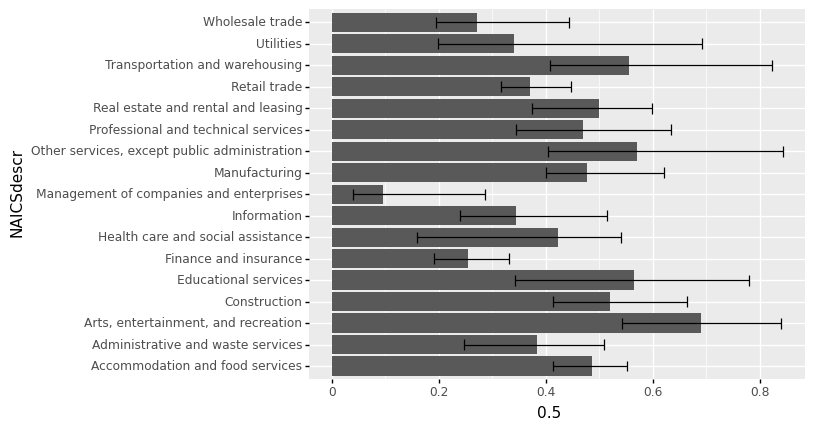

<ggplot: (8782351947861)>

In [ ]:
col='penetration'
dfq = pen_st.reset_index()
dfq = dfq[~dfq['NAICS2'].isin(['11','21','99'])][['NAICSdescr',col]].groupby('NAICSdescr').quantile([0.05,0.5,0.95]
        ).reset_index().pivot_table(index='level_1',columns='NAICSdescr',values=col)
#dfq = pen_st.reset_index()[~pen_st['NAICS2'].isin(['11','21','99'])][['NAICSdescr',col]].groupby('NAICSdescr').quantile([0.05,0.5,0.95]
#        ).reset_index().pivot_table(index='level_1',columns='NAICSdescr',values=col)
dfq.index = dfq.index.map(str)
dfq = dfq.transpose().reset_index()
ggplot(dfq, aes(x='NAICSdescr', y='0.5')
    ) + geom_bar(stat="identity" #, color="black", position=position_dodge()
    ) + geom_errorbar( aes(ymin='0.05', ymax='0.95') #, width=.2, position=position_dodge(.9)\
    ) + coord_flip()

####  Summaries

In [ ]:
print(scope, 'Total Number of PPP loans:', loans.shape[0])
print(scope, 'Total Number of PPP loans, excluding ' + ''.join(soleprop) 
                                                  + ': ' + str(loansc.shape[0]))
print(scope, 'Previous Number excluding loans with missing info: ' 
                                                  + str(pen['NLoans'].sum()))
print(scope, 'BLS Total Count of businesses: ' + str(pen['NEstabs'].sum()))
print(scope, 'Total Number of County-NAICS pairs with existing businesses: ' 
                                                  + str(pen.shape[0]))
print(scope, 'Previous Number with penetration > 1: ' + str(sum(pen['penetration'].gt(1))))
print(scope, 'Previous Number with penetration = 0: ' + str(sum(pen['penetration'].eq(0))))

US Total Number of PPP loans: 5156850
US Total Number of PPP loans, excluding Independent ContractorsSole ProprietorshipTenant in Common: 4194074
US Previous Number excluding loans with missing info: 4010344.0
US BLS Total Count of businesses: 9422840
US Total Number of County-NAICS pairs with existing businesses: 58928
US Previous Number with penetration > 1: 4900
US Previous Number with penetration = 0: 6622


### Correlation of LoanAmount with weekly wage

#### Overall median loan and wage

In [ ]:
print(scope, 'Average Total Quarterly Wages per Establishment: {0:,.0f}'.format(
                                     pen['total_qtrly_wages'].sum() / pen['NEstabs'].sum() ))
print(scope, 'Average Loan Amount: {0:,.0f}'.format( pen['TotLoanAmount'].sum() 
                                                         / pen['NLoans'].sum() ))
print(scope, 'Median Total Quarterly Wages per Establishment: {0:,.0f}'.format( 
                                     pen['TotQtrWagesperEstab'].median() ))
print(scope, 'Median Loan Amount: {0:,.0f}'.format( pen['AvgLoanAmount'].median() ))

US Average Total Quarterly Wages per Establishment: 201,814
US Average Loan Amount: 120,415
US Median Total Quarterly Wages per Establishment: 47,518
US Median Loan Amount: 60,999


#### distribution of total_qtrly_wages per NAICS

In [ ]:
dfq = pen[[naics,'TotQtrWagesperEstab']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='TotQtrWagesperEstab')
dfq.index = dfq.index.map(str)
print('     Quantiles (Total Quarterly Wages per Establishment per county)')
print('     ')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',0):  # more options can be specified also
    print(dfq.transpose())

     Quantiles (Total Quarterly Wages per Establishment per county)
     
level_1     0.5    0.75   0.95   0.99  0.999    1.0
NAICS2                                             
11        17647   52851  1e+05  2e+05  6e+05  1e+06
21            0  142545  6e+05  2e+06  5e+06  9e+06
22            0  360957  1e+06  3e+06  7e+06  1e+07
23        59475   98842  2e+05  4e+05  7e+05  5e+06
31-33    393572  707996  1e+06  2e+06  5e+06  8e+06
42        92422  156178  3e+05  5e+05  8e+05  9e+05
44-45     76249  101547  1e+05  2e+05  3e+05  7e+05
48-49     70822  170240  4e+05  7e+05  2e+06  4e+06
51        65988  137955  4e+05  8e+05  3e+06  6e+06
52        77585  118569  3e+05  8e+05  3e+06  5e+06
53        22966   41531  1e+05  2e+05  4e+05  8e+05
54        38701   73853  2e+05  5e+05  9e+05  3e+06
55        41451  360065  2e+06  5e+06  1e+07  2e+07
56        51143  112382  2e+05  4e+05  1e+06  2e+06
61        24129  116298  4e+05  1e+06  2e+06  2e+06
62        74124  172378  3e+05  5e+05  8e+

#### distribution of AvgLoanAmount per NAICS

In [ ]:
dfq = pen[[naics,'AvgLoanAmount']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='AvgLoanAmount')
dfq.index = dfq.index.map(str)
print('     Quantiles (Average Loan Amount per county)')
print('     ')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',0):  # more options can be specified also
    print(dfq.transpose())

     Quantiles (Average Loan Amount per county)
     
level_1     0.5    0.75   0.95   0.99  0.999    1.0
NAICS2                                             
11        42347   71090  2e+05  3e+05  7e+05  9e+05
21        96058  197622  6e+05  2e+06  7e+06  7e+06
22        94564  268109  1e+06  2e+06  5e+06  7e+06
23        86888  133935  2e+05  3e+05  9e+05  2e+06
31-33    159429  268459  5e+05  8e+05  2e+06  4e+06
42       104647  179702  4e+05  7e+05  2e+06  6e+06
44-45     71470  100545  1e+05  2e+05  3e+05  4e+05
48-49     68093  115628  2e+05  4e+05  8e+05  3e+06
51        54608  113754  3e+05  8e+05  2e+06  3e+06
52        40605   64242  1e+05  3e+05  5e+05  1e+06
53        33344   58557  1e+05  2e+05  5e+05  8e+05
54        52962   85402  2e+05  2e+05  6e+05  9e+05
55        75327  178600  7e+05  2e+06  3e+06  3e+06
56        55305   95002  2e+05  4e+05  1e+06  2e+06
61        86503  171588  5e+05  1e+06  4e+06  4e+06
62       142259  210372  4e+05  9e+05  2e+06  2e+06
71        

#### Scatterplot of Loan Amount vs wage

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 2080 rows containing missing values.


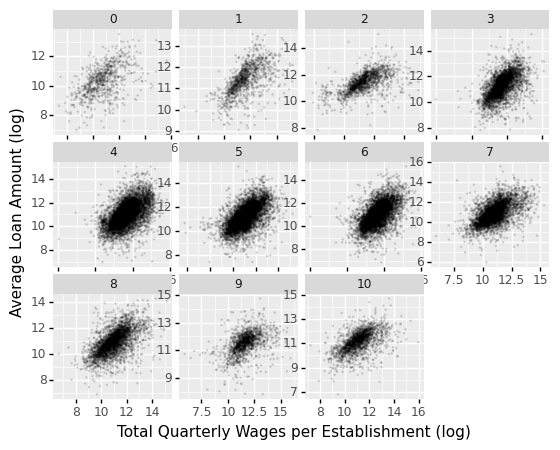

<ggplot: (8782344183929)>

In [ ]:
ggplot(pen[pen['TotQtrWagesperEstab'] > 0], aes(x='logTotQtrWagesperEstab', y='logAvgLoanAmount')
    ) + facet_wrap('~ Region', scales='free'  #, nrow=2 
    ) + geom_point( size=0.1, alpha=0.1
#    ) + coord_trans( x="log", y="log"
    ) + xlab('Total Quarterly Wages per Establishment (log)'
    ) + ylab('Average Loan Amount (log)')

In [ ]:
tmp = pen[pen['Region'].ne(0) & pen['AvgLoanAmount'].gt(0) & pen['TotQtrWagesperEstab'].gt(0)
           ][['logAvgLoanAmount','logTotQtrWagesperEstab','NAICS2','Region']]
olsdf = pd.concat((tmp, 
             pd.get_dummies(tmp['NAICS2'], prefix='NAICS', drop_first=False),
             pd.get_dummies(tmp['Region'], prefix='Region', drop_first=False)), axis=1)
y = olsdf['logAvgLoanAmount']
# X: remove dependent var, columns transformed to dummies, and columns to drop to avoid perfect collinearity
X = olsdf.drop(columns=['logAvgLoanAmount','NAICS2','Region','NAICS_72','Region_1'])
X = sm.add_constant(X)   # add column for intercept

In [ ]:
mod = sm.OLS(y, X)    # Describe model
res = mod.fit()       # Fit model
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       logAvgLoanAmount   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     886.1
Date:                Fri, 19 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:40:28   Log-Likelihood:                -44142.
No. Observations:               40247   AIC:                         8.834e+04
Df Residuals:                   40217   BIC:                         8.860e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6

from https://www.statsmodels.org/devel/gettingstarted.html: 

In [ ]:
sm.stats.linear_rainbow(res)

(0.9830301834054735, 0.8875604758111669)

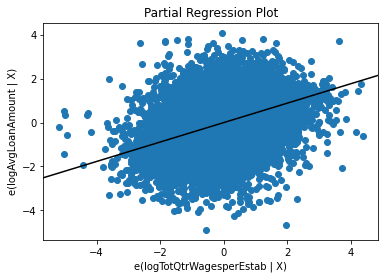

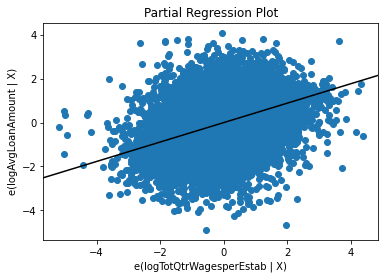

In [ ]:
sm.graphics.plot_partregress(endog='logAvgLoanAmount', exog_i='logTotQtrWagesperEstab'
                             , exog_others=['NAICS2','Region'], data=olsdf, obs_labels=False)

# SUPPLEMENTARY INFORMATION

In [ ]:
distribution of NLoans per NAICS

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


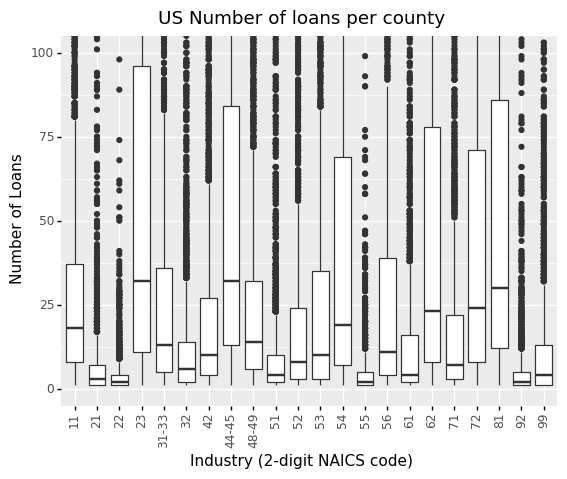

<ggplot: (8782345717045)>

In [ ]:
ggplot(loansum.reset_index(), aes(x=naics, y='NLoans')
    ) + geom_boxplot(
#    ) + scale_y_log10(labels=lambda l: ["%d" % v for v in l]
    ) + coord_cartesian(ylim=[0, 100]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle(scope + ' Number of loans per county' 
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Number of Loans')

In [ ]:
dfq = loansum['NLoans'].reset_index().groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='NLoans')
dfq.index = dfq.index.map(str)
print('            Quantiles (Number of Loans per state)')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',0):  # more options can be specified also
    print(dfq.transpose())

            Quantiles (Number of Loans per state)
level_1  0.5  0.75  0.95  0.99  0.999    1.0
NAICS2                                      
11        18    37    94   178    419    578
21         3     7    31   110    554    799
22         2     4    14    35    102    159
23        32    96   591  1579   4236   7604
31-33     13    36   226   718   2038   6578
32         6    14    84   240    636   1629
42        10    27   207   737   2941   9631
44-45     32    84   501  1560   5188  12553
48-49     14    32   174   644   2790   4540
51         4    10    93   360    985   6863
52         8    24   202   637   2115   4343
53        10    35   296   918   2903   7304
54        19    69   765  2846   9022  20737
55         2     5    32   108    235    345
56        11    39   322  1064   3022   6556
61         4    16   146   465   1099   2822
62        23    78   618  2146   6625  17467
71         7    22   155   470   1318   7282
72        24    71   466  1552   4416  10256
81   

##### distribution of avg_wkly_wage per NAICS

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


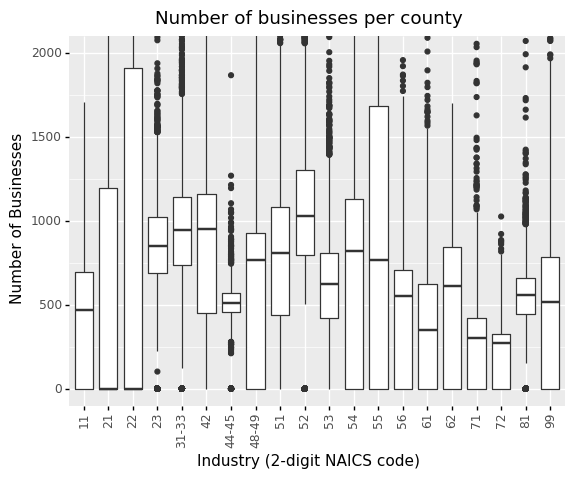

<ggplot: (8782351997873)>

In [ ]:
ggplot(pen, aes(x=naics, y='avg_wkly_wage')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 2000]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle('Average Weekly Wage per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Average Weekly Wage')

#### Scatterplot of Loan Amount vs wage

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/facets/facet.py:558: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:464: PlotnineWarning: geom_point : Removed 2076 rows containing missing values.


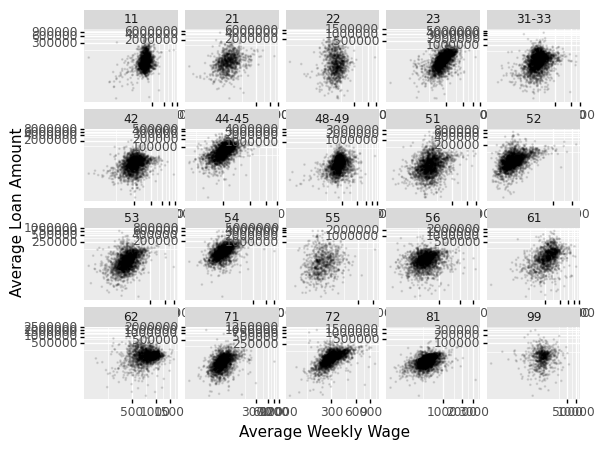

<ggplot: (8782345221317)>

In [ ]:
ggplot(pen[pen['avg_wkly_wage'] > 0], aes(x='avg_wkly_wage', y='AvgLoanAmount')
      ) + facet_wrap('~ NAICS2', scales='free'  #, nrow=2 
    ) + geom_point( size=0.1, alpha=0.1
    ) + coord_trans( x="log2", y="log2"
    ) + xlab('Average Weekly Wage'
    ) + ylab('Average Loan Amount')

##### distribution of NEstabs per NAICS

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


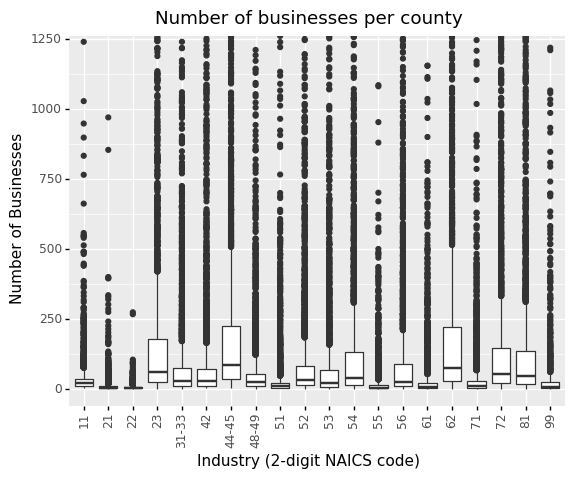

<ggplot: (8782350144209)>

In [ ]:
ggplot(pen, aes(x=naics, y='NEstabs')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 1200]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle('Number of businesses per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Number of Businesses')

In [ ]:
dfq = pen[[naics,'NEstabs']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='NEstabs')
dfq.index = dfq.index.map(str)
print('     Quantiles (Number of businesses per county)')
print('     ')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',0):  # more options can be specified also
    print(dfq.transpose())

     Quantiles (Number of businesses per county)
     
level_1  0.5  0.75  0.95  0.99  0.999     1.0
NAICS2                                       
11        19    35    98   289    939    1533
21         3     8    42   136    631    1339
22         4     7    21    50     98     273
23        59   179  1125  3195   8029   17206
31-33     28    74   461  1216   4758   12569
42        26    72   627  2393   8193   21178
44-45     85   223  1384  3925  11592   28946
48-49     23    54   293  1007   3433    8880
51         8    21   181   879   2545   13517
52        31    81   630  2152   7161   13361
53        19    66   574  2141   6631   17405
54        38   130  1518  5770  18493   42575
55         4    14   116   399   1082    1340
56        24    88   744  2415   6614   13625
61         6    22   210   709   1983    4206
62        73   221  1776  7003  31821  244826
71         9    28   203   627   1583   16888
72        51   144   966  3152   9428   23443
81        44   133  1048 

#### distribution of penetration per NAICS

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_boxplot : Removed 51 rows containing non-finite values.
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


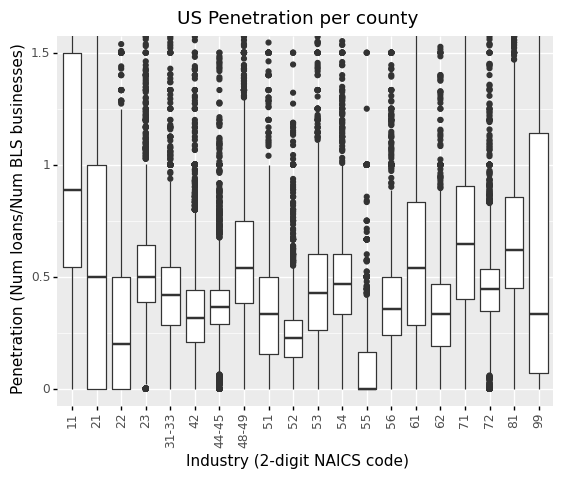

<ggplot: (8782350558449)>

In [ ]:
ggplot(pen, aes(x=naics, y='penetration')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 1.5]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle(scope + ' Penetration per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Penetration (Num loans/Num BLS businesses)')

In [ ]:
dfq = pen[[naics,'penetration']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='penetration')
dfq.index = dfq.index.map(str)
print('           Quantiles (Penetration per county)')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',2):  # more options can be specified also
    print(dfq.transpose())

           Quantiles (Penetration per county)
level_1   0.5  0.75   0.95    0.99   0.999     1.0
NAICS2                                            
11       0.89  1.50   3.40    6.00   12.00   15.00
21       0.50  1.00   2.00    4.00    6.42   18.00
22       0.20  0.50   1.04    2.00    5.17    7.00
23       0.50  0.64   1.04    2.33   15.34  110.00
31-33    0.42  0.55   1.00    2.00    6.76   38.17
42       0.31  0.44   0.93    2.00   12.26   41.00
44-45    0.36  0.44   0.72    1.43    6.07   44.29
48-49    0.54  0.75   1.36    3.00    7.33   46.00
51       0.33  0.50   1.00    2.00    6.00   55.00
52       0.22  0.31   0.50    1.19    6.96   48.12
53       0.43  0.60   1.20    3.00   18.92   92.67
54       0.47  0.60   1.00    3.00   25.50  119.56
55       0.00  0.16   0.57    1.00    3.61   25.00
56       0.36  0.50   1.00    3.00   16.27   76.17
61       0.54  0.83   2.00    4.00   10.22   22.33
62       0.33  0.47   0.74    2.00    8.54   59.89
71       0.65  0.91   1.68    4.00  

#### LoanAmount per business per NAICS

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_boxplot : Removed 6622 rows containing non-finite values.
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


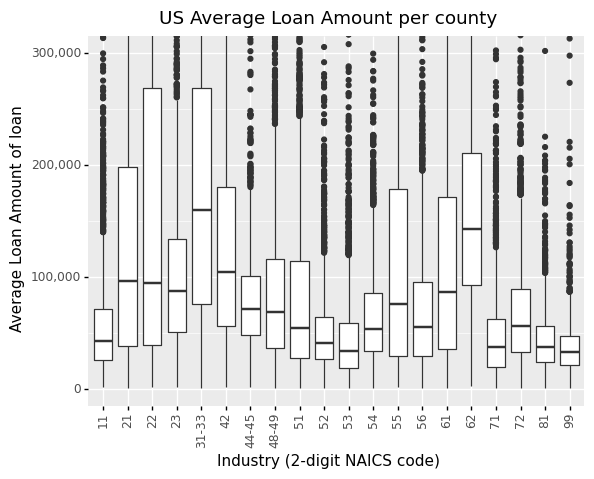

<ggplot: (8782350578393)>

In [ ]:
ggplot(pen, aes(x=naics, y='AvgLoanAmount')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 3e5]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle(scope + ' Average Loan Amount per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Average Loan Amount of loan'
    ) + scale_y_continuous(labels=lambda l: [f"{v:,.0f}" for v in l])

In [ ]:
dfq = pen[[naics,'AvgLoanAmount']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='AvgLoanAmount')
dfq.index = dfq.index.map(str)
print('           Quantiles (Average Loan Amount per county)')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',2):  # more options can be specified also
    print(dfq.transpose())

           Quantiles (Average Loan Amount per county)
level_1        0.5       0.75      0.95      0.99     0.999       1.0
NAICS2                                                               
11        42347.37   71090.21  1.66e+05  2.95e+05  6.81e+05  8.54e+05
21        96057.88  197621.67  6.18e+05  1.70e+06  6.55e+06  7.48e+06
22        94563.70  268109.02  1.17e+06  2.27e+06  4.52e+06  7.22e+06
23        86888.04  133934.76  2.31e+05  3.49e+05  9.40e+05  1.53e+06
31-33    159429.00  268458.81  5.33e+05  8.48e+05  1.93e+06  4.00e+06
42       104647.38  179701.68  3.60e+05  6.83e+05  1.72e+06  5.90e+06
44-45     71470.40  100544.62  1.48e+05  2.19e+05  3.26e+05  3.80e+05
48-49     68092.69  115628.39  2.30e+05  4.37e+05  8.31e+05  3.00e+06
51        54607.99  113754.13  3.01e+05  8.33e+05  2.24e+06  3.40e+06
52        40604.59   64241.58  1.29e+05  2.53e+05  5.23e+05  1.37e+06
53        33344.38   58556.66  1.24e+05  2.42e+05  5.40e+05  7.50e+05
54        52962.12   85402.42  1.57e

#### LoanAmount per Job per NAICS

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_boxplot : Removed 7365 rows containing non-finite values.
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


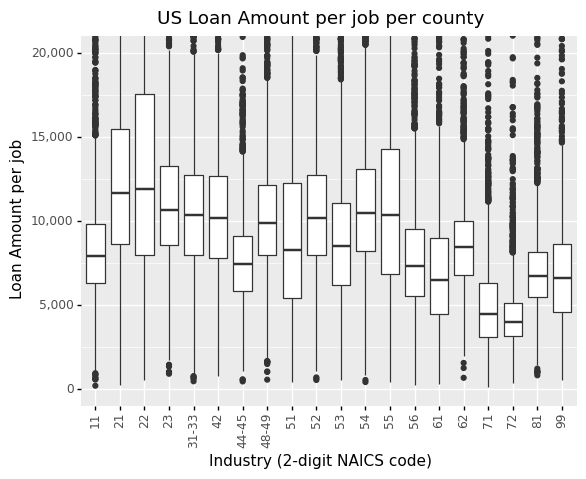

<ggplot: (8782350760377)>

In [ ]:
ggplot(pen, aes(x=naics, y='LoanAmtperEmp')
    ) + geom_boxplot(
    ) + coord_cartesian(ylim=[0, 2e4]
    ) + theme(axis_text_x=element_text(rotation=90, hjust=0.5)
    ) + ggtitle(scope + ' Loan Amount per job per county'
    ) + xlab('Industry (2-digit NAICS code)'
    ) + ylab('Loan Amount per job'
    ) + scale_y_continuous(labels=lambda l: [f"{v:,.0f}" for v in l])

In [ ]:
dfq = pen[[naics,'LoanAmtperEmp']].groupby(naics).quantile([0.5,0.75,0.95,0.99,0.999,1]
        ).reset_index().pivot_table(index='level_1',columns=naics,values='LoanAmtperEmp')
dfq.index = dfq.index.map(str)
print('           Quantiles (Loan Amount per job per county)')
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.precision',2):  # more options can be specified also
    print(dfq.transpose())

           Quantiles (Loan Amount per job per county)
level_1       0.5      0.75      0.95       0.99      0.999       1.0
NAICS2                                                               
11        7888.19   9816.63  15954.70   38681.70  139468.95  2.94e+05
21       11653.08  15488.65  26293.81   79361.85  338544.12  5.76e+05
22       11916.67  17527.92  27390.90   91369.62  518086.74  3.97e+06
23       10632.16  13260.31  18872.71   33497.80  119674.56  7.69e+05
31-33    10318.05  12750.11  19211.35   45666.24  319575.76  1.21e+06
42       10144.27  12687.29  19465.76   46247.54  255166.01  7.17e+05
44-45     7448.28   9113.10  12210.20   18989.84   82639.33  2.72e+05
48-49     9893.10  12144.29  19015.88   42843.64  209324.26  3.47e+05
51        8280.16  12246.16  19849.25   41890.70  126888.85  6.05e+05
52       10176.67  12750.03  19546.39   41612.54  118460.70  2.61e+05
53        8501.60  11055.29  18495.47   50214.65  174642.28  6.41e+05
54       10442.46  13083.83  19743.6

#### total per NAICS

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


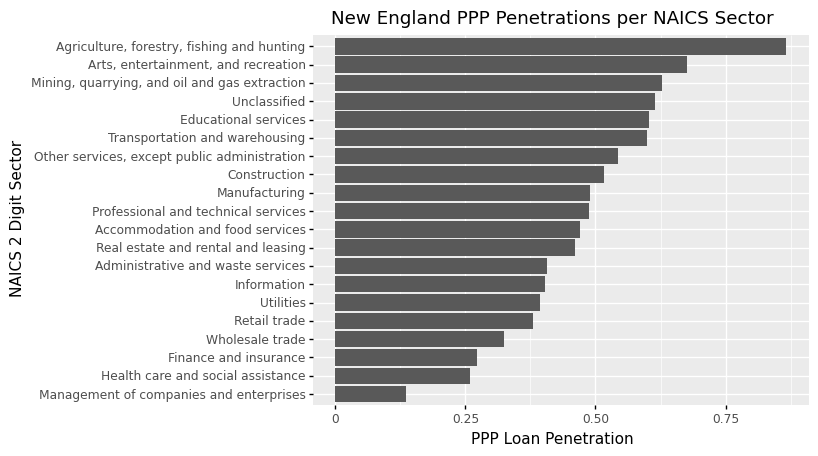

<ggplot: (8782350556201)>

In [ ]:
dfp = pen.groupby([naics,'NAICSdescr']).agg('sum').reset_index()
dfp['penetration'] = dfp['NLoans'] / dfp['NEstabs']

ggplot(dfp, aes(x='reorder(NAICSdescr,penetration)', y='penetration')
          ) + geom_bar(stat="identity"
          ) + xlab('NAICS 2 Digit Sector'
          ) + ylab('PPP Loan Penetration'
          ) + ggtitle('New England PPP Penetrations per NAICS Sector'
#          ) + scale_y_continuous(trans = 'log2'
          ) + coord_flip()

In [ ]:
ggplot(dfp[dfp['penetration'].gt(1)], aes(x='reorder(NAICSdescr,penetration)', y='penetration')
          ) + geom_bar(stat="identity"
          ) + xlab(naics + ' Sector'
          ) + ylab('PPP Loan Penetration'
          ) + ggtitle('New England PPP Penetrations > 1 per NAICS Sector'
#          ) + scale_y_continuous(trans = 'log2'
          ) + coord_flip()

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


IndexError: arrays used as indices must be of integer (or boolean) type

#### Histogram of County-NAICS penetrations

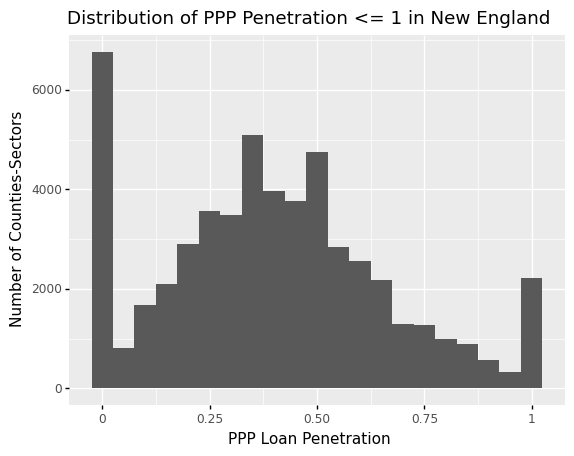

<ggplot: (8782350557073)>

In [ ]:
ggplot(pen[pen.penetration.le(1)], aes(x='penetration')
       ) + geom_histogram(binwidth=.05
       ) + xlab('PPP Loan Penetration'
       ) + ylab('Number of Counties-Sectors'
       ) + ggtitle('Distribution of PPP Penetration <= 1 in New England')

#### outlier penetrations

/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:369: PlotnineWarning: stat_boxplot : Removed 51 rows containing non-finite values.
/Users/aligo/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


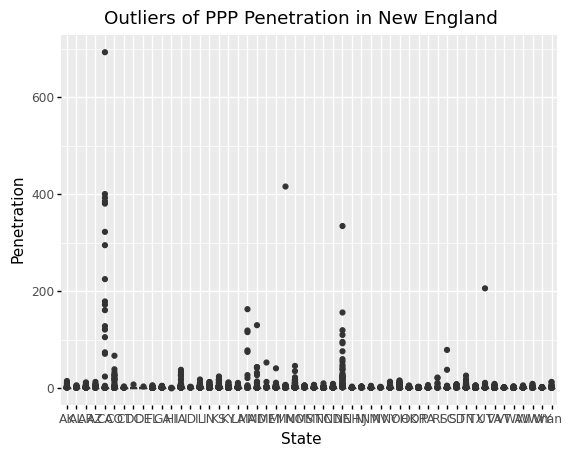

<ggplot: (8782350577261)>

In [ ]:
ggplot(pen, aes(x='State', y='penetration')
       ) + geom_boxplot(
       ) + xlab('State'
       ) + ylab('Penetration'
       ) + ggtitle('Outliers of PPP Penetration in New England')

#with pd.ExcelWriter(fpath + 'PPP.xlsx') as writer:
#    dfsum[['State','City','Zip','NAICS3','NAICSdescr','TotalAmount','NumLoans'
#           ,'JobsReported']].to_excel(writer, sheet_name='PPP', index=False)

#### Save for SBA paper

In [ ]:
with pd.ExcelWriter(fpath + 'SBApaperPPPpenetBLS_County_' + naics + scope + '.xlsx') as writer:
    pen[['State','COUNTYfips','COUNTYName',naics,'NAICSdescr','NEstabs','total_qtrly_wages','avg_wkly_wage','NLoans'
              ,'penetration','AvgLoanAmount','AvgJobsReported','LoanAmtperEmp']
                            ].to_excel(writer, sheet_name='PPP', index=False)

# debug
with pd.ExcelWriter('/Users/aligo/Downloads/tmp/ppp_loans_bls_counts.xlsx') as writer:
#    loansc.reset_index().to_excel(writer, sheet_name='loans')
    cnt.reset_index().to_excel(writer, sheet_name='bls')

US Total Number of PPP loans: 5156850
US Total Number of PPP loans, excluding Independent ContractorsSole ProprietorshipTenant in Common: 4194074
US Previous Number excluding loans with missing info: 4010344.0
US BLS Total Count of businesses: 9422840
US Total Number of County-NAICS pairs with existing businesses: 58928
US Previous Number with penetration > 1: 4900
US Previous Number with penetration = 0: 6622
